In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

plt.rcParams['figure.figsize'] = [20, 10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gaastra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Gaastra\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
df_all_news = pd.read_csv('data/us_equities_news_dataset.csv')

In [3]:
# Check datatypes in news dataframe
print(f'{df_all_news.dtypes}\n')

# Let convert_dtypes() find best suited dtypes for columns
df_all_news = df_all_news.convert_dtypes()

# Check datatypes in news dataframe after convert_dtypes()
print(f'{df_all_news.dtypes}\n')

# Convert 'release_date' to DateTime object
df_all_news['release_date'] = pd.to_datetime(df_all_news['release_date'], format='%Y-%m-%d')

# Check datatypes in news dataframe after manual fixing
print(f'{df_all_news.dtypes}\n')

id               int64
ticker          object
title           object
category        object
content         object
release_date    object
provider        object
url             object
article_id       int64
dtype: object

id                       Int64
ticker          string[python]
title           string[python]
category        string[python]
content         string[python]
release_date    string[python]
provider        string[python]
url             string[python]
article_id               Int64
dtype: object

id                       Int64
ticker          string[python]
title           string[python]
category        string[python]
content         string[python]
release_date    datetime64[ns]
provider        string[python]
url             string[python]
article_id               Int64
dtype: object



In [4]:
# Count duplicates in 'content' column
print(f"Duplicates found 'content' column: {df_all_news['content'].duplicated().sum()}")
# Remove duplicates in 'content' column
df_all_news.drop_duplicates('content', inplace=True)


# Count NVIDIA related articles
# print(f"NVIDIA related articles: {df_all_news[df_all_news['ticker'] == 'NVDA']['id'].count()}")
# Filter DataFrame on NVIDIA related articles
# df_news = df_all_news[df_all_news['ticker'] == 'NVDA'].copy()

# print(f"NVIDIA related articles: {df_all_news[df_all_news['ticker'] == 'NVDA']['id'].count()}")
# df_news = df_all_news[df_all_news['ticker'] == 'NVDA'].copy()

print(f"NVIDIA related articles: {df_all_news[df_all_news['content'].str.lower().str.contains("nvidia")]['id'].count()}")
df_news = df_all_news[df_all_news['content'].str.lower().str.contains("nvidia")].copy()

# Convert content to all lowercase
df_news['content'] = df_news['content'].apply(str.lower)

# Add 'word_count' column containing word count per article
df_news['word_count'] = df_news.apply(lambda row: len(row.content.split(' ')), axis=1)

Duplicates found 'content' column: 516
NVIDIA related articles: 3384


In [5]:
eng_stopwords = set(stopwords.words('english'))

def tokenize(content):
    tokens = content.split(' ')
    return tokens

def clean_tokens(tokens):
    cleaned = [token for token in tokens if (token != '' and token not in eng_stopwords) and token.isalpha()]
    return cleaned

def join_tokens(tokens):
    return ' '.join(tokens)

# Tokenize 'content' and store in 'tokens'
df_news['tokens'] = df_news['content'].apply(tokenize)

# Clean 'tokens' by removing empty tokens, removing stopwords and removing punctuation and numbers
df_news['tokens'] = df_news['tokens'].apply(clean_tokens)

# Join 'tokens' together and store in 'content'
df_news['content'] = df_news['tokens'].apply(join_tokens)


In [6]:
# Perform pos-tagging on corpus
unique_token_set = set(" ".join(df_news['content']).split(" "))
unique_token_tagged = pos_tag(unique_token_set, tagset='universal')
tag_abbrev_dict = {"NOUN": "n",
                   "VERB": "v",
                   "ADJ": "a",
                   "ADV": "r"}

# Build token/pos-tag dictionary
unique_token_tagged_abbrev = [(token, tag_abbrev_dict[pos_tag]) for (token, pos_tag) in unique_token_tagged if pos_tag in tag_abbrev_dict.keys()]

# Lemmatize tokens
lemmatizer = WordNetLemmatizer()
lemmatized_tokens_dict = {token: lemmatizer.lemmatize(token, pos=pos_tag) for (token, pos_tag) in unique_token_tagged_abbrev}

In [7]:
def lemmatize_content(tokens, lemmatize_dict):
    lemmatized_tokens = [lemmatize_dict[token] if token in lemmatize_dict.keys() else token for token in tokens]
    return ' '.join(lemmatized_tokens)

df_news['content'] = df_news['tokens'].apply(lemmatize_content, lemmatize_dict=lemmatized_tokens_dict)
df_news

,id,ticker,title,category,content,release_date,provider,url,article_id,word_count,tokens
24,221539,NIO,A Central Bank War Just Started And Its Good F...,opinion,ecb move euro huge fall pip huge important pie...,2019-03-07,Michael Kramer,https://www.investing.com/analysis/a-central-b...,200395687,784,"[ecb, move, euro, huge, falling, pips, huge, i..."
32,221547,NIO,6 Stocks To Watch Nivida Could Be Falling,opinion,stock watch march trading go pretty much nowhe...,2019-03-06,Michael Kramer,https://www.investing.com/analysis/6-stocks-to...,200394931,618,"[stocks, watch, march, trading, went, pretty, ..."
57,221572,NIO,Stocks Dow Drops Nearly 400 Points as Apple ...,news,invest com rout apple facebook nasdaq fb monda...,2018-11-19,Investing.com,https://www.investing.com/news/stock-market-ne...,1694042,578,"[investing, com, rout, apple, facebook, nasdaq..."
78,221593,UBER,The Zacks Analyst Blog Highlights Advanced Mi...,opinion,immediate releasechicago il january zacks com ...,2020-01-12,Zacks Investment Research,https://www.investing.com/analysis/the-zacks-a...,200498277,1849,"[immediate, releasechicago, il, january, zacks..."
82,221597,UBER,The Best Of CES 2020 Revised,opinion,company bringing innovation ce jan get really ...,2020-01-16,Zacks Investment Research,https://www.investing.com/analysis/the-best-of...,200499164,1515,"[companies, bringing, innovations, ces, jan, g..."
...,...,...,...,...,...,...,...,...,...,...,...
221141,442657,AMD,Here s Why Nvidia NVDA Stock Is Gaining Today,opinion,share nvidia nasdaq nvda nearly tuesday solid ...,2016-09-27,Zacks Investment Research,https://www.investing.com/analysis/here's-why-...,200155860,272,"[shares, nvidia, nasdaq, nvda, nearly, tuesday..."
221166,442682,AMD,4 Stocks To Watch Today ATW CWEI MXL SLCA,opinion,pretty good start week monday mean wood mean a...,2016-05-17,Harry Boxer,"https://www.investing.com/analysis/atw,-cwei,-...",200130262,697,"[pretty, good, start, week, monday, mean, wood..."
221189,442705,AMD,Here s What The Buy Side Expects From AMD Thur...,opinion,advance micro device inc nyse amd set report e...,2014-04-17,Estimize,https://www.investing.com/analysis/here’s-what...,209915,785,"[advanced, micro, devices, inc, nyse, amd, set..."
221468,442984,T,Zacks com Featured Highlights AT T Nu Skin E...,opinion,immediate il july stock week article include n...,2016-07-21,Zacks Investment Research,https://www.investing.com/analysis/zacks.com-f...,200143537,1749,"[immediate, il, july, stocks, week, article, i..."


Since we filter on whether or not it contains the 'nvidia' token, every article will contain atleast the 'nvidia' token. This means this token will add no information, so we choose to remove it ('nvda' is also removed).

In [8]:
# Function to remove tokens from 'content' column
def remove_tokens(tokens, remove_tokens):
    return [token for token in tokens if token not in remove_tokens]

# Remove 'nvidia' and 'nvda' tokens
df_news['tokens'] = df_news['tokens'].apply(remove_tokens, remove_tokens=['nvidia', 'nvda'])
df_news['content'] = df_news['tokens'].apply(join_tokens)

<Axes: xlabel='tokens'>

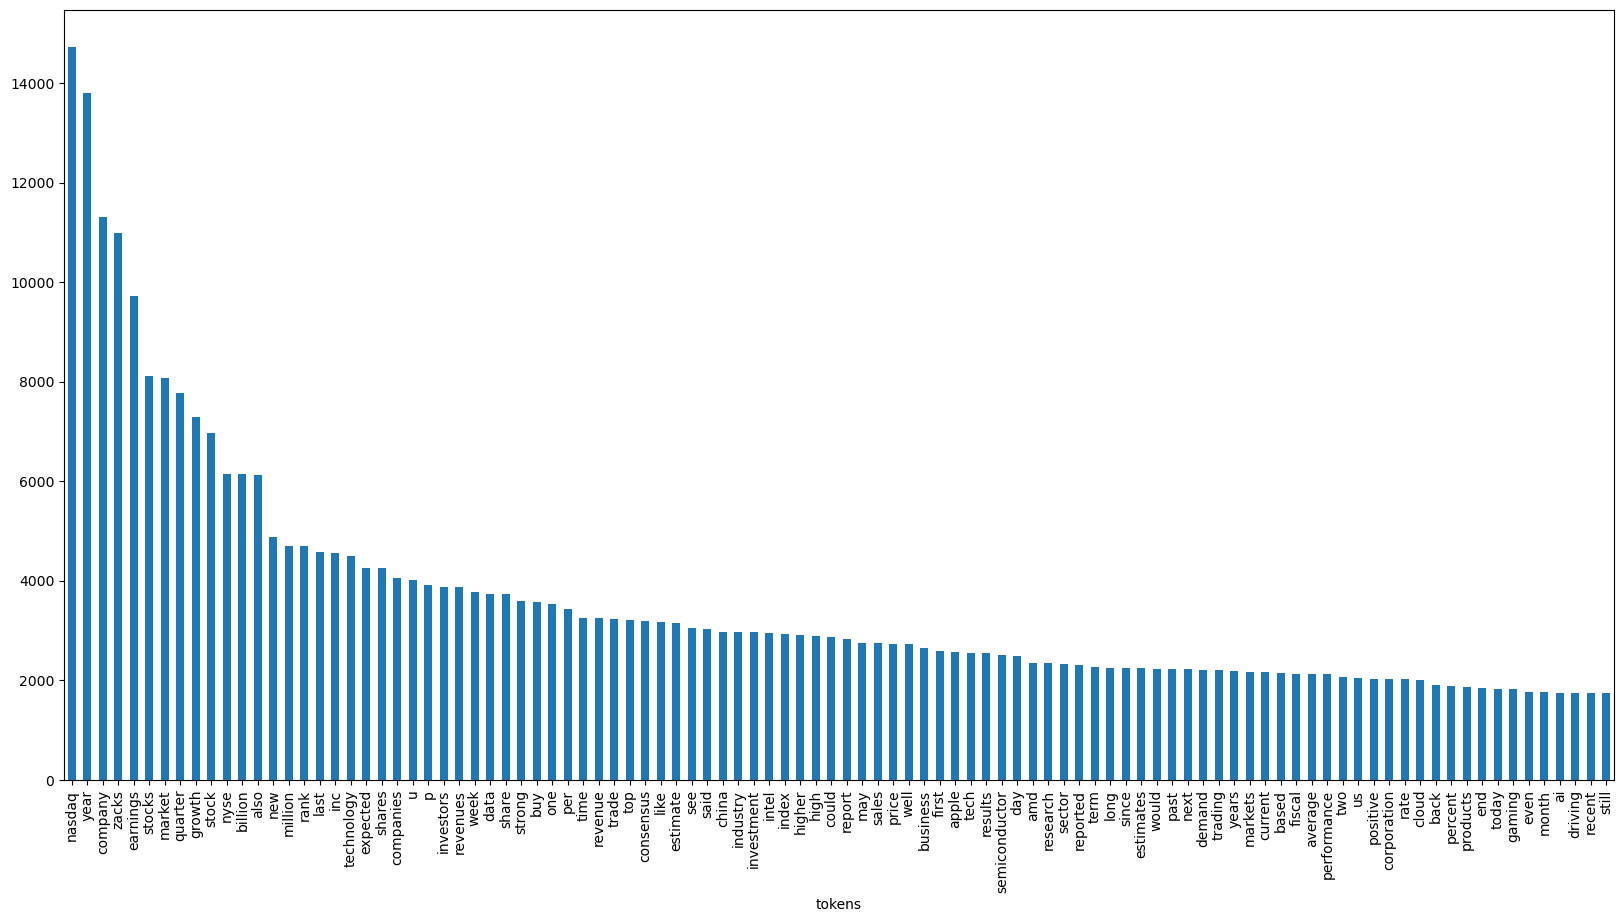

In [9]:
# Build corpus
corpus = df_news['tokens'].explode()
# Plot top 100 words in corpus
corpus.value_counts()[0:100].plot(kind='bar')

The histogram shows that the 'u' are 'p' tokens are prevalent in the corpus. As these are non valid words and probably leftovers HTML tags from the scraping process we choose to remove them.

<Axes: xlabel='tokens'>

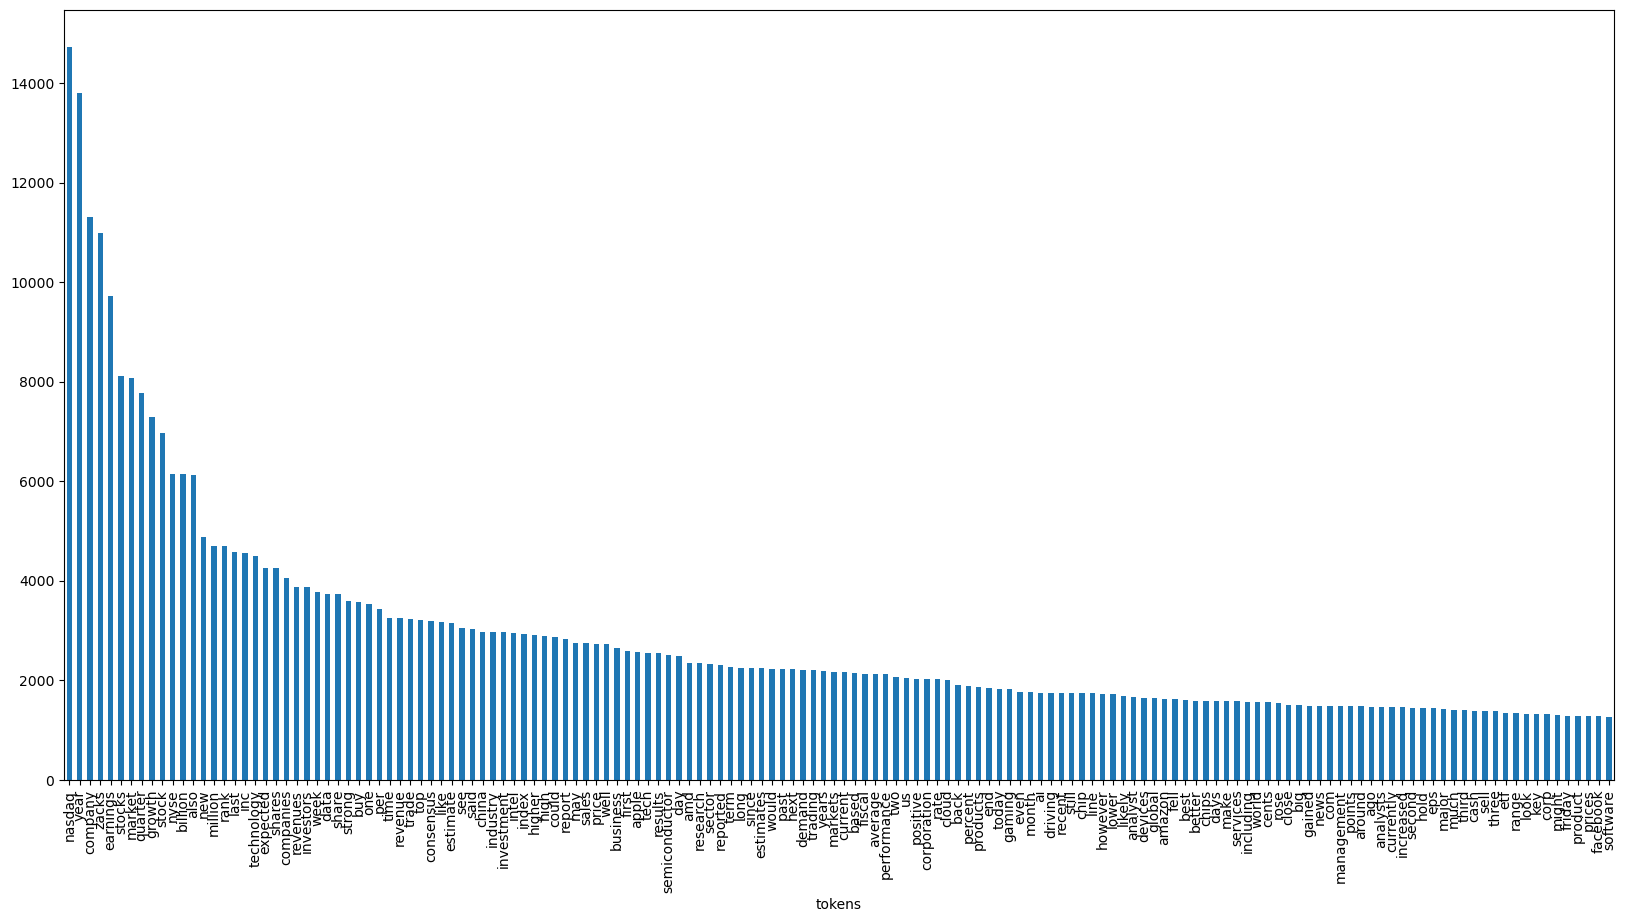

In [10]:
# Remove 'u' and 'nvpda' tokens
df_news['tokens'] = df_news['tokens'].apply(remove_tokens, remove_tokens=['u', 'p'])
df_news['content'] = df_news['tokens'].apply(join_tokens)
# Build corpus
corpus = df_news['tokens'].explode()
# Plot top 100 words in corpus
corpus.value_counts()[0:150].plot(kind='bar')

There are still alot of domain-specific keywords that do not really add information in the corpus. However, when using bi- or tri-grams these words may reveal patterns (e.g. nasdaq rose, stock market volatility) that may contain useful information. The choice is made to keep these words in the corpus. Due to this fact the choice has also been made to use an n_gram_range = (1,3) to keep TLAs (Three Letter Abbreviations) that are often used in domain specific jargon.

# BERTopic

In [11]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from transformers.pipelines import pipeline
from umap import UMAP
from hdbscan import HDBSCAN
import gensim.corpora as corpora
from gensim.models import CoherenceModel

c:\Users\Gaastra\anaconda3\envs\my_nlp_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def build_coherence_model(model, topics):
    # Extract vectorizer and analyzer from BERTopic
    vectorizer = model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in df_news['content']]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in model.get_topic(topic)] 
                for topic in range(len(set(topics))-1)]
    
    coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
    return coherence_model

## Basic Model

In [13]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(list(df_news['content']), show_progress_bar=False)

In [44]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [45]:
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [46]:
default_topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, n_gram_range=(1,3), verbose=True)
default_topics, default_probs = default_topic_model.fit_transform(df_news['content'], embeddings)

2024-11-06 15:52:15,606 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-06 15:52:27,387 - BERTopic - Dimensionality - Completed ✓
2024-11-06 15:52:27,388 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-06 15:52:27,478 - BERTopic - Cluster - Completed ✓
2024-11-06 15:52:27,480 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-06 15:52:37,253 - BERTopic - Representation - Completed ✓


In [47]:
default_topic_model.get_topic_info()[['Topic', 'Count', 'Representation']]

,Topic,Count,Representation
0,-1,1069,"[nasdaq, year, zacks, earnings, company, stock..."
1,0,180,"[quarter, million, year, company, zacks, reven..."
2,1,171,"[driving, self, self driving, autonomous, vehi..."
3,2,169,"[nyse, nasdaq, trade, china, week, fed, dow, f..."
4,3,155,"[gaming, year, quarter, company, billion, reve..."
5,4,154,"[amd, graphics, gpu, year, radeon, market, qua..."
6,5,123,"[semiconductor, zacks, earnings, industry, sto..."
7,6,95,"[target, price target, price, shares, nasdaq, ..."
8,7,75,"[intel, ai, chips, data, nasdaq, cloud, new, c..."
9,8,59,"[tech, nasdaq, stocks, etf, growth, technology..."


In [48]:
default_topic_model.visualize_topics()

In [ ]:
default_topic_model.visualize_heatmap()

In [49]:
hierarchical_topics = default_topic_model.hierarchical_topics(df_news['content'])
default_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 44/44 [00:01<00:00, 33.45it/s]


<Axes: xlabel='Representation'>

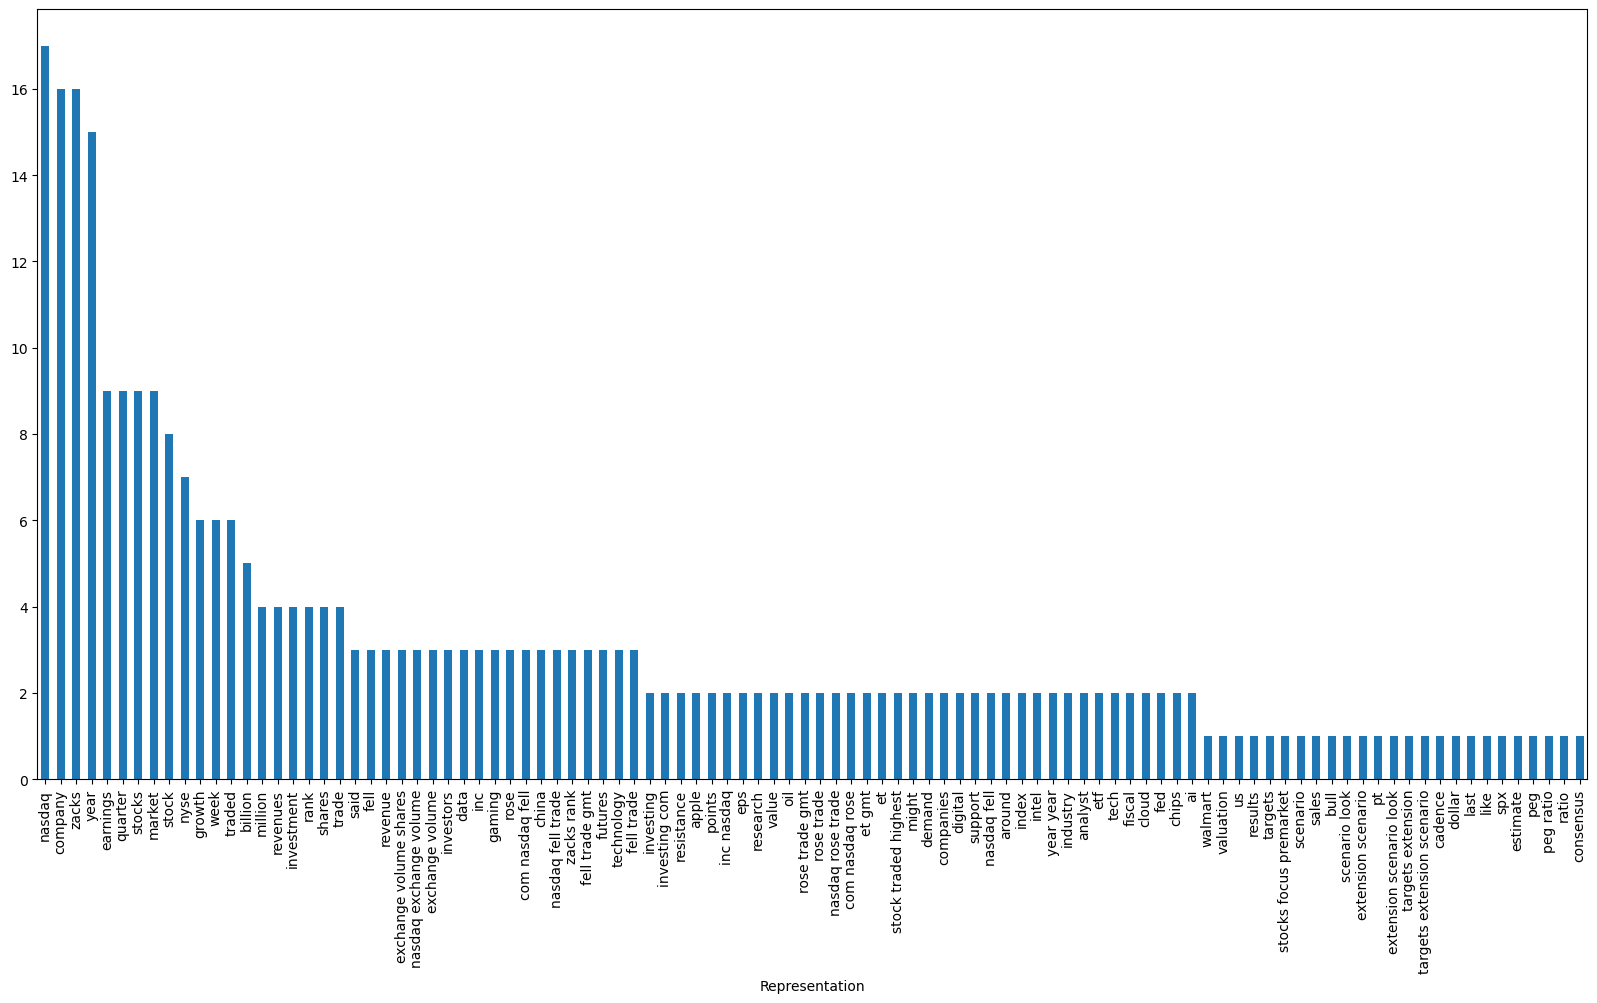

In [50]:
# Explore representation words
rep_words = default_topic_model.get_topic_info()['Representation'].explode()
rep_words.value_counts()[0:100].plot(kind='bar')

We can see in this histogram of representative words, that a lot of the topics are dominated by 'nasdaq', 'company', 'zacks' and 'year'. Removing these tokens could improve topic quality, so lets try that.

In [51]:
# Remove 'nvidia' and 'nvda' tokens
df_news['tokens'] = df_news['tokens'].apply(remove_tokens, remove_tokens=['nasdaq', 'company', 'zacks', 'year'])
df_news['content'] = df_news['tokens'].apply(join_tokens)

In [52]:
default_topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, n_gram_range=(1,3), verbose=True)
default_topics, default_probs = default_topic_model.fit_transform(df_news['content'], embeddings)

2024-11-06 15:54:03,462 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-06 15:54:15,561 - BERTopic - Dimensionality - Completed ✓
2024-11-06 15:54:15,561 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-06 15:54:15,651 - BERTopic - Cluster - Completed ✓
2024-11-06 15:54:15,654 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-06 15:54:25,628 - BERTopic - Representation - Completed ✓


In [53]:
default_topic_model.get_topic_info()[['Topic', 'Count', 'Representation']]

,Topic,Count,Representation
0,-1,1069,"[earnings, stocks, market, growth, stock, bill..."
1,0,180,"[quarter, million, revenues, earnings, rank, c..."
2,1,171,"[driving, self, self driving, autonomous, vehi..."
3,2,169,"[nyse, trade, china, week, fed, dow, fell, mar..."
4,3,155,"[gaming, quarter, billion, revenues, million, ..."
5,4,154,"[amd, graphics, gpu, radeon, market, quarter, ..."
6,5,123,"[semiconductor, earnings, industry, stocks, ra..."
7,6,95,"[target, price target, price, shares, gaming, ..."
8,7,75,"[intel, ai, chips, data, cloud, new, chip, inf..."
9,8,59,"[tech, stocks, etf, growth, technology, sector..."


In [54]:
default_topic_model.visualize_topics()

In [55]:
default_topic_model.visualize_heatmap()

In [57]:
hierarchical_topics = default_topic_model.hierarchical_topics(df_news['content'])
default_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 44/44 [00:01<00:00, 34.05it/s]


<Axes: xlabel='Representation'>

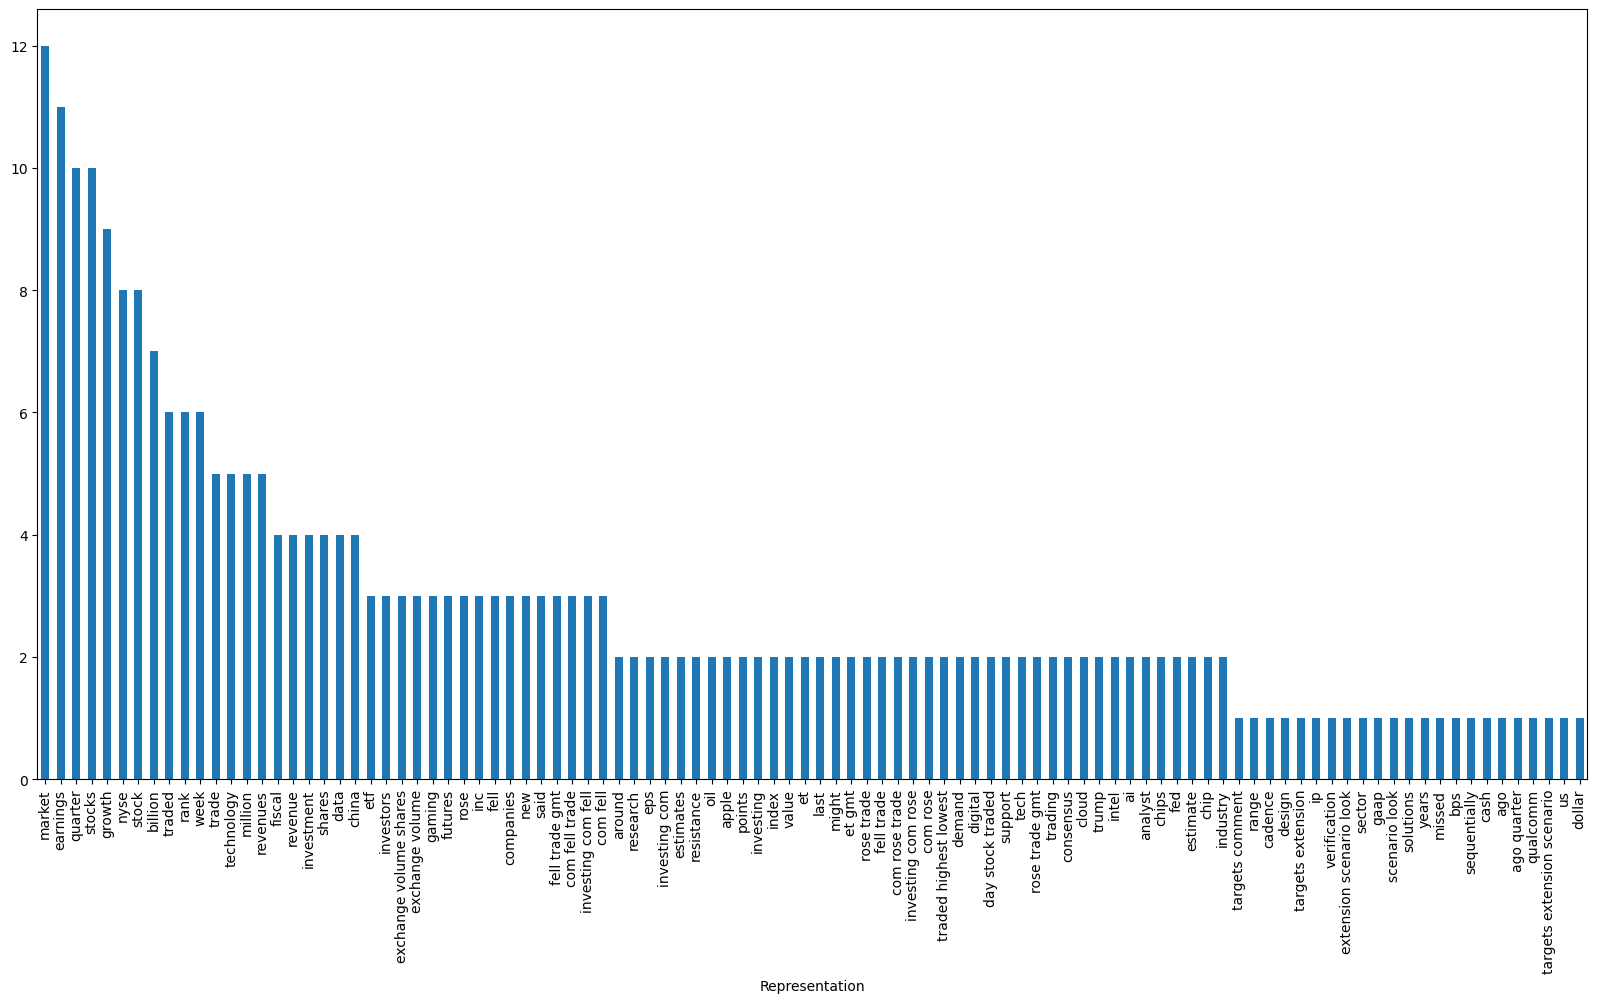

In [56]:
# Explore representation words
rep_words = default_topic_model.get_topic_info()['Representation'].explode()
rep_words.value_counts()[0:100].plot(kind='bar')

From qualitative analysis, the topics seem to be more coherent for human interpretation. There are however still closely related topics that are not clustered. In the hierarchical clustering figure we can see that

In [ ]:
hdbscan_model_v2 = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
default_topic_model_v2 = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model_v2, n_gram_range=(1,3), nr_topics=29, verbose=True)

In [81]:
default_topics_v2, default_probs_v2 = default_topic_model_v2.fit_transform(df_news['content'], embeddings)

2024-11-06 16:18:54,854 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-06 16:19:06,337 - BERTopic - Dimensionality - Completed ✓
2024-11-06 16:19:06,338 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-06 16:19:06,433 - BERTopic - Cluster - Completed ✓
2024-11-06 16:19:06,435 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-06 16:19:15,365 - BERTopic - Representation - Completed ✓


In [82]:
hierarchical_topics_v2 = default_topic_model_v2.hierarchical_topics(df_news['content'])
default_topic_model_v2.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 18/18 [00:00<00:00, 22.44it/s]


In [83]:
default_topic_model_v2.visualize_heatmap()

### Topic tuning

In [43]:
nr_topics = ['auto', 5, 10, 20, 50, 100, 150, 200]
models = []
topics = []

for nr_topic in nr_topics:
    print(f'n_topic: {nr_topic}')
    nr_topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, n_gram_range=(1,3), nr_topics=nr_topic, verbose=True)
    nr_topics, _ = nr_topic_model.fit_transform(df_news['content'], embeddings)
    nr_c_model = build_coherence_model(nr_topic_model, nr_topics)
    print(nr_c_model.get_coherence())
    models.append(nr_topic_model)
    topics.append(nr_topics.copy())



2024-11-06 15:46:36,149 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


n_topic: auto


2024-11-06 15:46:47,757 - BERTopic - Dimensionality - Completed ✓
2024-11-06 15:46:47,758 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-06 15:46:47,847 - BERTopic - Cluster - Completed ✓
2024-11-06 15:46:47,848 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-06 15:46:55,379 - BERTopic - Representation - Completed ✓
2024-11-06 15:46:55,396 - BERTopic - Topic reduction - Reducing number of topics
2024-11-06 15:47:03,751 - BERTopic - Topic reduction - Reduced number of topics from 46 to 3
2024-11-06 15:48:09,512 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


0.9401270617832205
n_topic: 5


2024-11-06 15:48:21,039 - BERTopic - Dimensionality - Completed ✓
2024-11-06 15:48:21,040 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-06 15:48:21,132 - BERTopic - Cluster - Completed ✓
2024-11-06 15:48:21,133 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-06 15:48:30,236 - BERTopic - Representation - Completed ✓
2024-11-06 15:48:30,254 - BERTopic - Topic reduction - Reducing number of topics
2024-11-06 15:48:38,839 - BERTopic - Topic reduction - Reduced number of topics from 46 to 5
2024-11-06 15:49:46,347 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


0.8072132777785602
n_topic: 10


2024-11-06 15:49:57,989 - BERTopic - Dimensionality - Completed ✓
2024-11-06 15:49:57,990 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-06 15:49:58,083 - BERTopic - Cluster - Completed ✓
2024-11-06 15:49:58,084 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-06 15:50:06,985 - BERTopic - Representation - Completed ✓
2024-11-06 15:50:07,004 - BERTopic - Topic reduction - Reducing number of topics
2024-11-06 15:50:15,691 - BERTopic - Topic reduction - Reduced number of topics from 46 to 10
2024-11-06 15:51:26,105 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


0.7781948134109915
n_topic: 20


2024-11-06 15:51:37,744 - BERTopic - Dimensionality - Completed ✓
2024-11-06 15:51:37,745 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-06 15:51:37,837 - BERTopic - Cluster - Completed ✓
2024-11-06 15:51:37,838 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-06 15:51:47,184 - BERTopic - Representation - Completed ✓
2024-11-06 15:51:47,203 - BERTopic - Topic reduction - Reducing number of topics
2024-11-06 15:51:56,393 - BERTopic - Topic reduction - Reduced number of topics from 46 to 20


KeyboardInterrupt: 

In [21]:

# Tune UMAP parameters
umap_model_v2 = UMAP(n_neighbors=15,  # Adjust for more general clusters
                  min_dist=0.1,    # Adjust for tighter or looser clusters
                  n_components=5,  # Increase for potentially better clustering
                  random_state=42)

# Tune HDBSCAN parameters
hdbscan_model_v2 = HDBSCAN(min_cluster_size=20,  # Increase for larger clusters
                        min_samples=15,       # Adjust for noise tolerance
                        cluster_selection_epsilon=0.1,  # Adjust to merge close clusters
                        prediction_data=True)

In [22]:
default_topic_model = BERTopic(umap_model=umap_model_v2, hdbscan_model=hdbscan_model_v2, n_gram_range=(1,3), verbose=True)
default_topics, default_probs = default_topic_model.fit_transform(df_news['content'], embeddings)

2024-11-06 15:34:53,230 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-06 15:35:04,190 - BERTopic - Dimensionality - Completed ✓
2024-11-06 15:35:04,190 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-06 15:35:04,286 - BERTopic - Cluster - Completed ✓
2024-11-06 15:35:04,289 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-06 15:35:13,879 - BERTopic - Representation - Completed ✓


In [23]:
default_topic_model.get_topic_info()[['Topic', 'Count', 'Representation']]

,Topic,Count,Representation
0,-1,1251,"[nasdaq, year, earnings, zacks, company, stock..."
1,0,217,"[quarter, year, million, company, zacks, reven..."
2,1,162,"[nyse, nasdaq, trade, china, week, dow, fell, ..."
3,2,151,"[amd, graphics, year, gpu, radeon, market, qua..."
4,3,149,"[driving, self, self driving, autonomous, vehi..."
5,4,149,"[gaming, year, quarter, company, billion, reve..."
6,5,116,"[revenue, shares, earnings, nasdaq, intel, tar..."
7,6,112,"[semiconductor, zacks, earnings, industry, sto..."
8,7,99,"[intel, chips, ai, data, nasdaq, chip, market,..."
9,8,90,"[analyst, zacks, zacks analyst, research, comp..."


In [24]:
default_topic_model.visualize_topics()

In [25]:
hierarchical_topics = default_topic_model.hierarchical_topics(df_news['content'])
default_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 33/33 [00:01<00:00, 24.29it/s]


In [26]:
default_topic_model.visualize_heatmap()

In [27]:
topics_to_merge = [
    [46, 30, 27, 38, 41],  # Trading and market-related topics
    [51, 35],              # Chipmaker and technology focus
    [10, 5],               # Futures and market performance topics
    [24, 49],              # Share performance and resistance analysis
    [29, 8, 28, 16, 69],   # Oil, stocks, and weekly performance clusters
    [63, 3, 19],           # Analysts, target prices, and reports
    [34, 53],              # AMD and cryptocurrency mining
    [60, 57],              # Gaming and technology topics
    [12, 1],               # AI and robotics themes
    [7, 55],               # Microsoft and cloud technologies
    [64, 54],              # Semiconductor and chip discussions
    [65, 33, 23],          # Chipmakers and performance analysis
    [14, 17, 26, 31],      # Revenue, industry performance, and rankings
    [13, 43, 62]           # Financial growth and earnings reports
]

In [28]:
default_topic_model.visualize_heatmap()

<Axes: xlabel='Representation'>

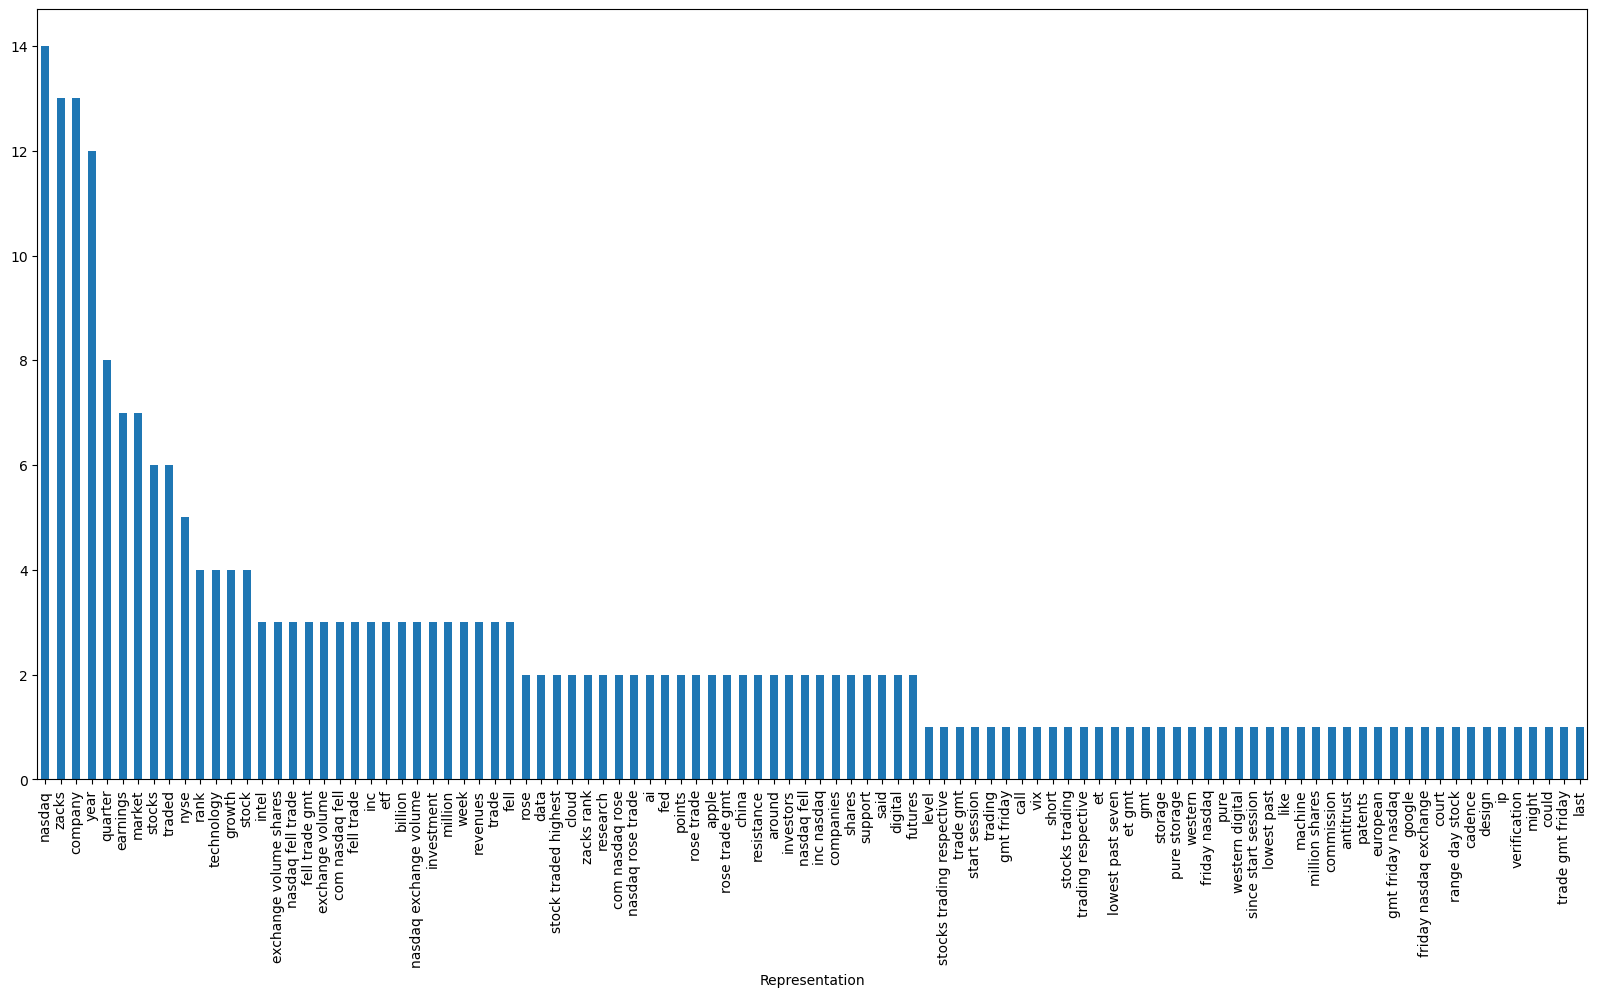

In [29]:
# Explore representation words
rep_words = default_topic_model.get_topic_info()['Representation'].explode()
rep_words.value_counts()[0:100].plot(kind='bar')

In [30]:
# Reduce outliers
new_topics = default_topic_model.reduce_outliers(df_news['content'], topics=default_topics, probabilities=default_probs, strategy="probabilities")

In [31]:
default_topic_model.visualize_heatmap()

### Word reduction using c-TF-IDF

In [32]:
from bertopic.vectorizers import ClassTfidfTransformer

ctfidf_model = ClassTfidfTransformer(bm25_weighting=True, reduce_frequent_words=True)
word_reduc_model = BERTopic(ctfidf_model=ctfidf_model, verbose=True)

In [33]:
word_reduc_topics, word_reduc_probs = word_reduc_model.fit_transform(df_news['content'], embeddings)

2024-11-06 15:35:23,543 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


2024-11-06 15:35:34,631 - BERTopic - Dimensionality - Completed ✓
2024-11-06 15:35:34,632 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-06 15:35:34,724 - BERTopic - Cluster - Completed ✓
2024-11-06 15:35:34,727 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-06 15:35:35,485 - BERTopic - Representation - Completed ✓


In [34]:
word_reduc_model.visualize_heatmap()

### Adjusting nr_topics

In [35]:
topics_auto_topic_model = BERTopic(verbose=True, n_gram_range=(1,2), nr_topics='auto')
topics_auto_topics, topics_auto_probs = topics_auto_topic_model.fit_transform(df_news['content'], embeddings)

2024-11-06 15:35:36,289 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-06 15:35:47,425 - BERTopic - Dimensionality - Completed ✓
2024-11-06 15:35:47,426 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-06 15:35:47,520 - BERTopic - Cluster - Completed ✓
2024-11-06 15:35:47,521 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-06 15:35:51,725 - BERTopic - Representation - Completed ✓
2024-11-06 15:35:51,732 - BERTopic - Topic reduction - Reducing number of topics
2024-11-06 15:35:55,825 - BERTopic - Topic reduction - Reduced number of topics from 70 to 4


In [36]:
topics_auto_topic_model.get_topic_info()[['Topic', 'Count', 'Representation']]

,Topic,Count,Representation
0,-1,1073,"[nasdaq, year, zacks, company, earnings, stock..."
1,0,2163,"[nasdaq, year, company, zacks, earnings, marke..."
2,1,75,"[traded, rose trade, exchange volume, session ..."
3,2,73,"[traded, fell trade, nasdaq fell, trade gmt, l..."


In [37]:
topics_auto_topic_model.visualize_topics()

c:\Users\Gaastra\anaconda3\envs\my_nlp_env\Lib\site-packages\umap\spectral.py:521: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

<Axes: xlabel='Representation'>

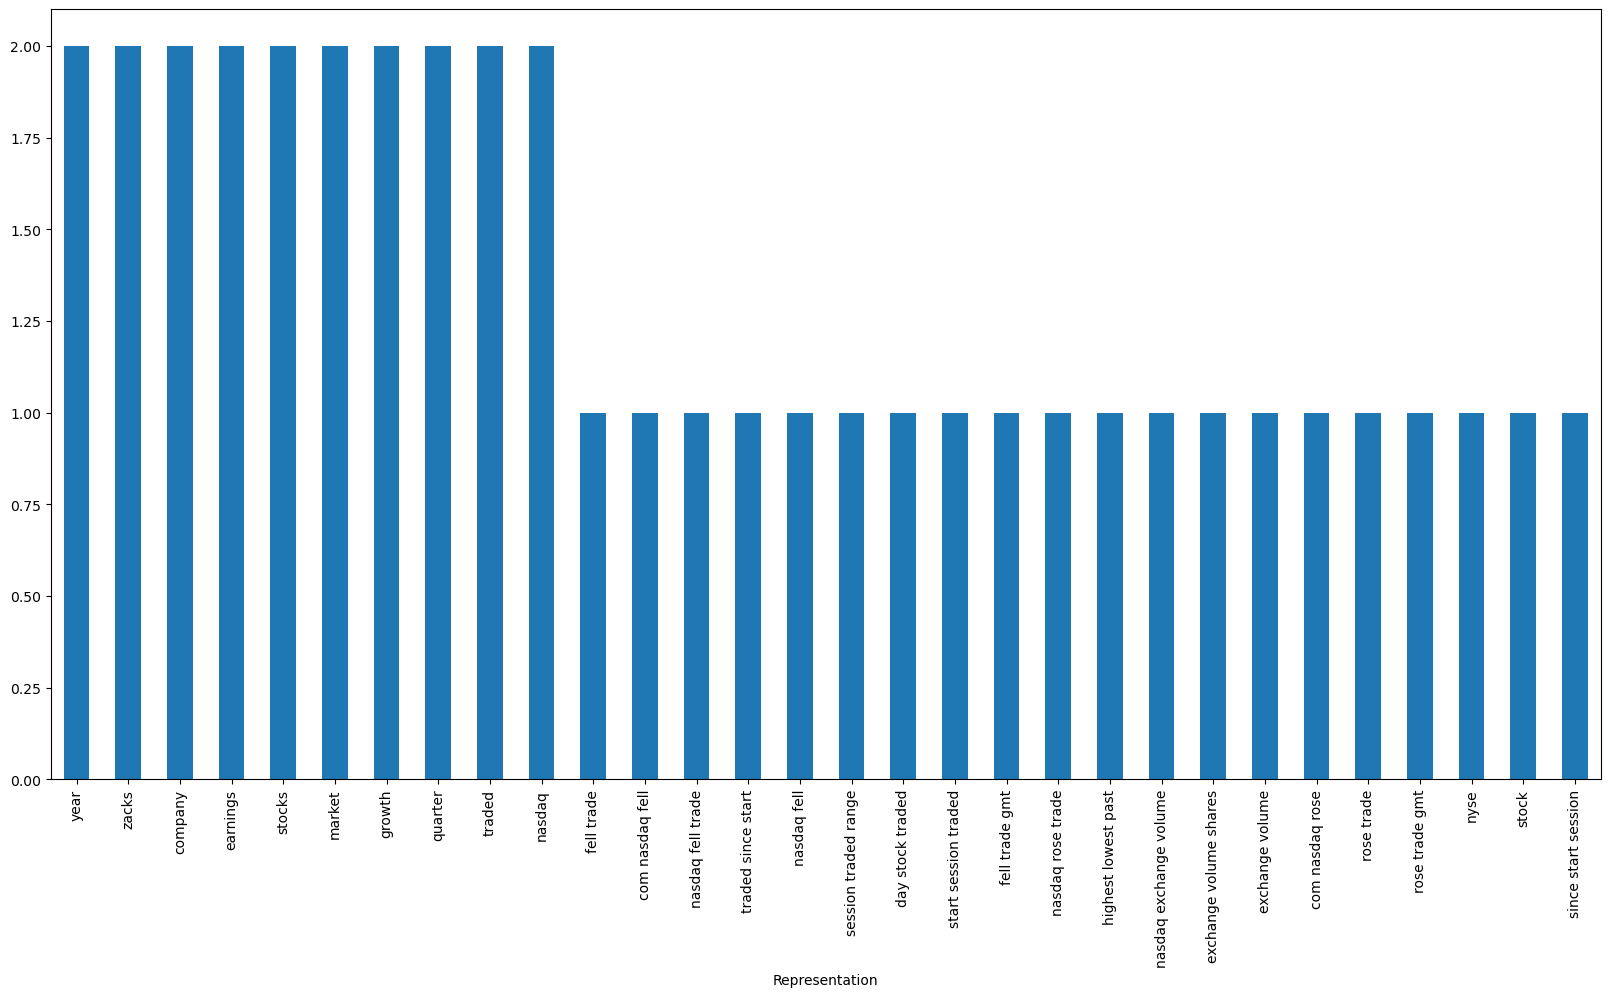

In [ ]:
# Explore representation words
rep_words = topics_auto_topic_model.get_topic_info()['Representation'].explode()
rep_words.value_counts()[0:100].plot(kind='bar')

In [ ]:
topics_auto_topic_model.visualize_heatmap()

### Adjusting n-gram range

In [ ]:
default_c_model = build_coherence_model(default_topic_model, default_topics)
default_c_model.get_coherence()

0.654805224230008

In [ ]:
n_2_topic_model = BERTopic(verbose=True, n_gram_range=(1,2), calculate_probabilities=False)
n_3_topic_model = BERTopic(verbose=True, n_gram_range=(1,3), calculate_probabilities=False)
n_4_topic_model = BERTopic(verbose=True, n_gram_range=(1,4), calculate_probabilities=False)
n_2_topics, _ = n_2_topic_model.fit_transform(df_news['content'], embeddings)
n_3_topics, _ = n_3_topic_model.fit_transform(df_news['content'], embeddings)
n_4_topics, _ = n_4_topic_model.fit_transform(df_news['content'], embeddings)

2024-11-05 13:24:57,702 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-05 13:25:07,809 - BERTopic - Dimensionality - Completed ✓
2024-11-05 13:25:07,810 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-05 13:25:07,900 - BERTopic - Cluster - Completed ✓
2024-11-05 13:25:07,903 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-05 13:25:11,067 - BERTopic - Representation - Completed ✓
2024-11-05 13:25:12,637 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-05 13:25:22,287 - BERTopic - Dimensionality - Completed ✓
2024-11-05 13:25:22,288 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-05 13:25:22,376 - BERTopic - Cluster - Completed ✓
2024-11-05 13:25:22,378 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-05 13:25:29,589 - BERTopic - Representation - Completed ✓
2024-11-05 1

In [ ]:
n_2_topic_model.get_topic_info()[['Topic', 'Count', 'Representation']]

,Topic,Count,Representation
0,-1,1097,"[nasdaq, year, zacks, company, stocks, earnings, market, growth, stock, nyse]"
1,0,154,"[amd, graphics, gpu, radeon, year, ryzen, processors, market, gaming, quarter]"
2,1,149,"[driving, self, self driving, autonomous, vehicles, cars, car, vehicle, automotive, technology]"
3,2,101,"[gaming, year, quarter, billion, company, revenues, fiscal, million, year year, gpus]"
4,3,82,"[target, price target, price, shares, data center, analyst, center, gaming, rating, nasdaq]"
5,4,77,"[semiconductor, earnings, zacks, industry, stocks, rank, etf, zacks rank, growth, score]"
6,5,74,"[tech, nasdaq, etf, stocks, growth, technology, year, sector, fund, fang]"
7,6,59,"[resistance, stock, towards, around, break, roku, nasdaq, think, higher, back]"
8,7,57,"[apple, iphone, year, billion, zacks, services, company, nasdaq, quarter, zacks rank]"
9,8,52,"[china, trade, trump, chinese, tariffs, companies, war, trade war, tariff, technology]"


In [ ]:
n_2_c_model = build_coherence_model(n_2_topic_model, n_2_topics)
print(n_2_c_model.get_coherence())
n_2_topic_model.visualize_heatmap()

0.6581118091307698


In [ ]:
n_3_c_model = build_coherence_model(n_3_topic_model, n_3_topics)
print(n_3_c_model.get_coherence())
n_3_topic_model.visualize_heatmap()

0.7234529570078209


In [ ]:
n_3_topic_model.visualize_heatmap()

In [ ]:
n_4_c_model = build_coherence_model(n_4_topic_model, n_4_topics)
print(n_4_c_model.get_coherence())
n_4_topic_model.visualize_heatmap()

0.7706142455552248


Editing the n-gram range does influence the topic similarity matrix. As we are working with news

## Modularization


In [19]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 120)

### Document embedding (FinBERT)

In [20]:
embedding_model = pipeline("feature-extraction", model="ProsusAI/finbert")

In [21]:
finbert_topic_model = BERTopic(embedding_model=embedding_model, n_gram_range=(1,2), verbose=True)

In [22]:
finbert_topics, probs = finbert_topic_model.fit_transform(df_news['content'])

2024-11-05 12:55:41,545 - BERTopic - Embedding - Transforming documents to embeddings.
100%|██████████| 3384/3384 [11:51<00:00,  4.75it/s]
2024-11-05 13:07:33,491 - BERTopic - Embedding - Completed ✓
2024-11-05 13:07:33,491 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-05 13:07:49,963 - BERTopic - Dimensionality - Completed ✓
2024-11-05 13:07:49,965 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-05 13:07:50,057 - BERTopic - Cluster - Completed ✓
2024-11-05 13:07:50,062 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-05 13:07:53,372 - BERTopic - Representation - Completed ✓


In [23]:
print(len(finbert_topic_model.get_topic_info()))
finbert_topic_model.get_topic_info()[['Topic', 'Count', 'Representation']].head()

72


,Topic,Count,Representation
0,-1,1169,"[year, company, earnings, zacks, nasdaq, growth, stocks, quarter, market, billion]"
1,0,110,"[amd, intel, ai, said, driving, nasdaq, self driving, self, read, chip]"
2,1,101,"[fund, etf, bitcoin, etfs, exposure, technology, index, top, sector, read]"
3,2,93,"[week, market, stock, today, trader, momentum, stocks, time, zacks, good]"
4,3,87,"[esp, zacks, earnings esp, zacks rank, rank, earnings, quarter, esp zacks, model, surprise]"


In [24]:
finbert_topic_model.visualize_topics()

<Axes: xlabel='Representation'>

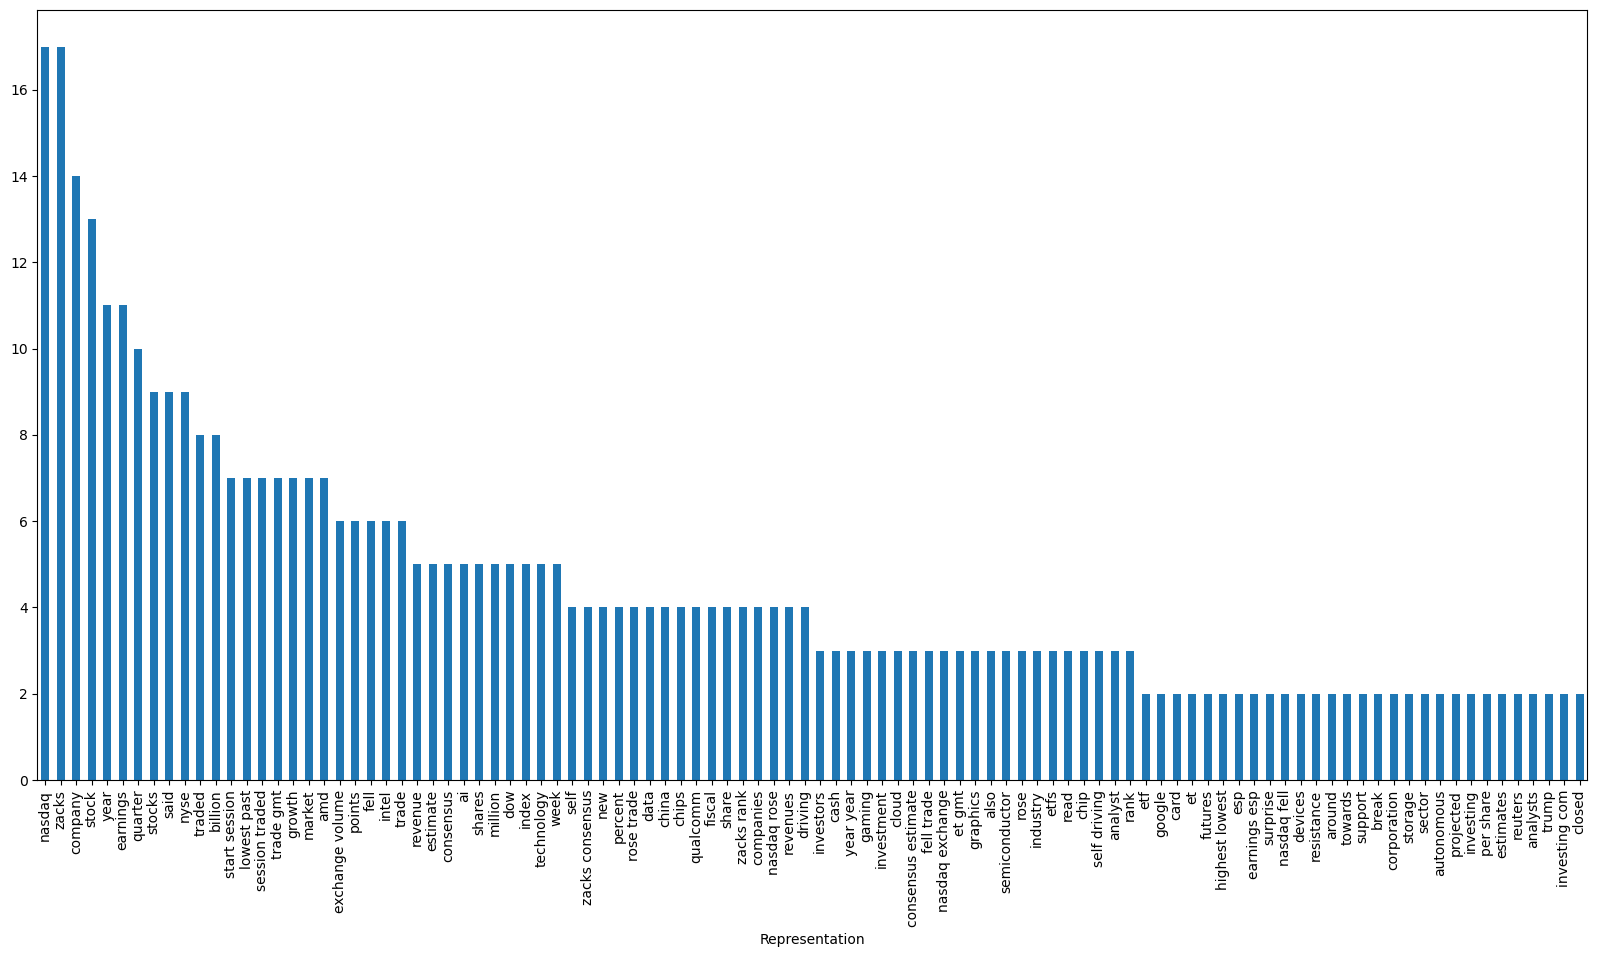

In [25]:
# Explore representation words
rep_words = finbert_topic_model.get_topic_info()['Representation'].explode()
# for i, word in rep_words.items():
#     print(i, word)

rep_words.value_counts()[0:100].plot(kind='bar')

In [26]:
finbert_topic_model.visualize_heatmap()

In [123]:
finbert_c_model = build_coherence_model(finbert_topic_model, finbert_topics)
finbert_c_model.get_coherence()

0.6680542583571493

### Dimensionality reduction (UMAP)

In [ ]:
umap_model = UMAP(n_components=5, n_neighbors=15, min_dist=0.0)

### Clustering (HDBscan)

In [ ]:
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [102]:
tuned_topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, n_gram_range=(1,2), verbose=True)

In [107]:
tuned_topics, probs = tuned_topic_model.fit_transform(list(df_news['content']), embeddings)

2024-11-04 17:19:40,677 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-04 17:19:49,791 - BERTopic - Dimensionality - Completed ✓
2024-11-04 17:19:49,792 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-04 17:19:49,882 - BERTopic - Cluster - Completed ✓
2024-11-04 17:19:49,885 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-04 17:19:53,147 - BERTopic - Representation - Completed ✓


In [114]:
tuned_c_model = build_coherence_model(tuned_topic_model, tuned_topics)
tuned_c_model.get_coherence()

0.6941111271778856

### Vectorization

### Evaluation (Coherence matrix)

In [85]:
finbert_topic_model.visualize_barchart()

In [86]:
finbert_topic_model.visualize_heatmap()

In [93]:
finbert_coherence

0.6165292732385659